# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
#### Import all the required basic libraries 

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt

In [3]:
#### Suppress all the warnings which are not necessary

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [4]:
#### Set seed value to reproduce the results in every run

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [5]:
## Print the available GPU name

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
base_path = "/content/gdrive/MyDrive/CNN/"
os.chdir(base_path) # Then we can use normal paths in train and val directory

In [8]:
!unzip -q -o Project_data.zip -d /

In [9]:
project_folder = '/Project_data'

In [10]:
train_file = project_folder + '/train.csv'
val_file = project_folder + '/val.csv'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [11]:
train_doc = np.random.permutation(open(train_file).readlines())
val_doc = np.random.permutation(open(val_file).readlines())

In [12]:
# Let us set the image height & width to 100x100 to maintain consistency in all images so that training will be performed well
image_resize_height = 100
image_resize_width = 100

In [13]:
# Initializing the training and validation path

train_path = project_folder + '/train/';
val_path = project_folder + '/val/';

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
# Lets have the method to resize and crop the images

# Inputs: 
#   * image: Image to crop and resize
#   * y,z: image height and width to resize
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

def normalizeImage(image):
    # applying normalization
    return image/255.0

# Normalize and crop image
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [15]:
def generator(source_path, folder_list, batch_size, imageDataNdShape):
    print( 'Source path = ', source_path, '; batch size = ', batch_size, '; imageDataNdShape = ', imageDataNdShape)
    img_idx = imageDataNdShape[0] # Selected Frames list
    x,y,z = len(imageDataNdShape[0]), imageDataNdShape[1], imageDataNdShape[2] # (no.Of frames Selected, Image height, Image width)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)!=0):
            batch_size = len(source_path)%batch_size
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [16]:
# Using current date and time to store the .h5 files including current date and time in its name
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [17]:
# Plot the model history as a line graph which helps in depicting the loss and accuracy of both training and validation

# Input: Model History
# Output: Graphs with max accuracy of training and validation set
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [18]:
# Returns the imageData in the format of (Randomly selected frames array, Image Height, Image Width, channel size)

# Input: no.of frames shuld selected
def getImageDataNdShape(total_frames):
  img_idx = np.round(np.linspace(0, 29, total_frames)).astype(int)
  return [img_idx, image_resize_height, image_resize_width, 3]

# Lets initialize the total frames to use as 20
total_frames = 30
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape); # Gets the frames for selected frame size and image width, height and channel size as a list format

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
### Imports required to build the models

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

In [19]:
### Define the base CNN Conv3d Model to experiement with
### Input: Image Data List which contains the frames selected, image width and height, channels size

def defineModel(imageDataNdShape):
  
  ### Extract Data from input
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)

  model = Sequential([
      Conv3D(16, (5, 5, 5), activation='relu', input_shape=inputShape),
      MaxPooling3D((2, 2, 2), padding='same'),
      BatchNormalization(),

      Conv3D(32, (3, 3, 3), activation='relu'),
      MaxPooling3D(pool_size=(1,2,2), padding='same'),
      BatchNormalization(),

      Conv3D(64, (3, 3, 3), activation='relu'),
      MaxPooling3D(pool_size=(1,2,2), padding='same'),
      BatchNormalization(),

      Flatten(),
      Dense(128, activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(64, activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(5, activation='softmax')
  ])
  return model

In [20]:
# Compile the given model for the given optimser
# Inputs: model and optimiser name
# Output: Sumamry of the model
def compileNdDisplaySummary(model, optimiser):
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model.summary()) # Prints the sumamry of the model

In [21]:
### Calculates the number of steps required per epoch in train and validation

# Input: number of training sequences, validation sequences and batch size
# Output: steps required per epoch in train and validation
def getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size):
  s, v = 0, 0;
  if (num_train_sequences%batch_size) == 0:
    s = int(num_train_sequences/batch_size)
  else:
    s = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      v = int(num_val_sequences/batch_size)
  else:
      v = (num_val_sequences//batch_size) + 1
  return s, v

In [42]:
# Test Model on small Batches or data to know about model accuracy
def testBatchSize(batch_size, total_frames):
    imageDataNdShape = getImageDataNdShape(total_frames)
    print("Using frames as", imageDataNdShape[0])
    
    callbacks_list = getCallBacksList('model_test')
    num_epochs = 3
    
    train_generator = generator(train_path, train_doc, batch_size, imageDataNdShape)
    val_generator = generator(val_path, val_doc, batch_size, imageDataNdShape)
    steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
    model = defineModel(imageDataNdShape)
    compileNdDisplaySummary(model, 'adam')
    modelHistory = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    plotModelHistory(modelHistory)

In [22]:
# returns the callback list based on the checkpoint requirement

# Input: modelName required to save model, is checkpoint required or not boolean (Default False, which means no need to save .h5 file)
# Output: Callbacks list
def getCallBacksList(modelName, reqCheckPoint = False):

  # Model or directory name to save output
  model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  # Create directory if not exists already
  if not os.path.exists(model_name):
      os.mkdir(model_name)
          
  # File name to save files in the directory
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  # Create a checkpoints which saves data output for every epoch
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  # Early stop which helps in stopping model if sufficient growth is not available in model
  #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

  # Adjust the learning rate during the model building automatically by network
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

  if reqCheckPoint:
    callbacks_list = [checkpoint, LR];
  else:
    callbacks_list = [LR];

  
  return callbacks_list

In [23]:
# Get the train and validation generators
def getTrainNdValGenerators(batchSize, imageDataNdShapeInfo):
  train_generator = generator(train_path, train_doc, batchSize, imageDataNdShapeInfo)
  val_generator = generator(val_path, val_doc, batchSize, imageDataNdShapeInfo)
  return train_generator, val_generator;

### Test models on sample test data and test model

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 6, 48, 48, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_49 (Bat  (None, 6, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_31 (Conv3D)          (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 4, 23, 23, 32)    0         
 g3D)                                                 

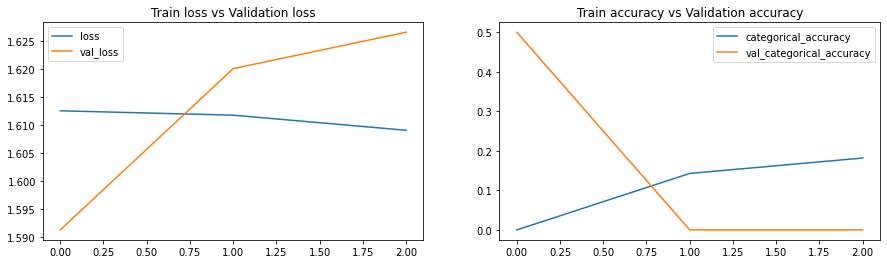

Max. Training Accuracy 0.1818181872367859
Max. Validaiton Accuracy 0.5


In [ ]:
# Commenting since it is optional and required only for testing purpose 
# testBatchSize(64, 16)

Using frames as [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 8, 48, 48, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_54 (Bat  (None, 8, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_34 (Conv3D)          (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 6, 23, 23, 32)    0         
 g3D)                                    

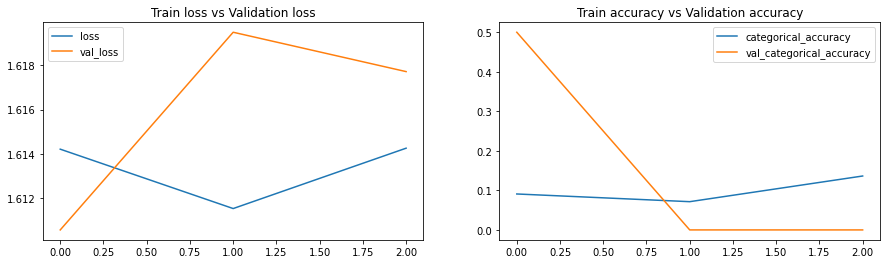

Max. Training Accuracy 0.13636364042758942
Max. Validaiton Accuracy 0.5


In [ ]:
# Commenting since it is optional and required only for testing purpose 
# testBatchSize(64, 20)

Using frames as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 13, 48, 48, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_59 (Bat  (None, 13, 48, 48, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_37 (Conv3D)          (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 11, 23, 23, 32)   0         
 g3D)     

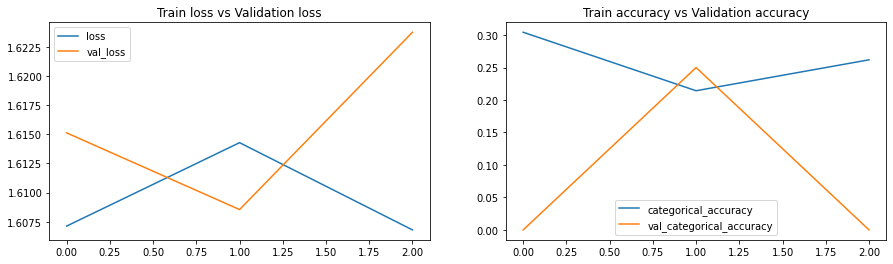

Max. Training Accuracy 0.30434781312942505
Max. Validaiton Accuracy 0.25


In [ ]:
# Commenting since it is optional and required only for testing purpose 
# testBatchSize(32, 30)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 6, 48, 48, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_64 (Bat  (None, 6, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_40 (Conv3D)          (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 4, 23, 23, 32)    0         
 g3D)                                                

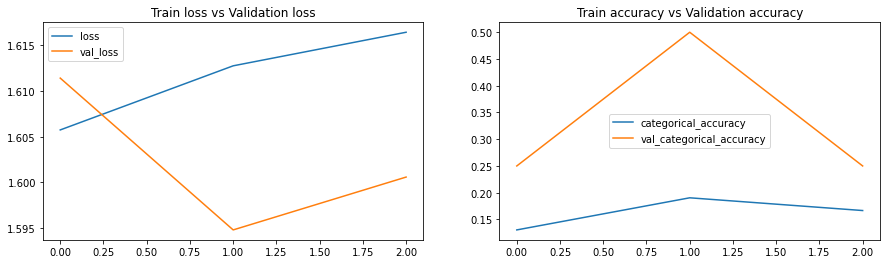

Max. Training Accuracy 0.190476194024086
Max. Validaiton Accuracy 0.5


In [ ]:
# Commenting since it is optional and required only for testing purpose 
# testBatchSize(32, 16)

Using frames as [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 8, 48, 48, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_69 (Bat  (None, 8, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_43 (Conv3D)          (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 6, 23, 23, 32)    0         
 g3D)                                    

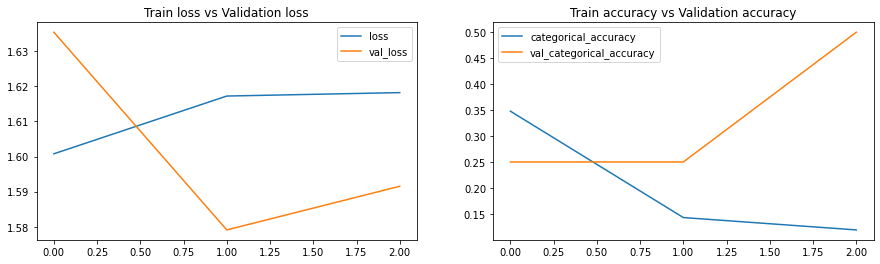

Max. Training Accuracy 0.3478260934352875
Max. Validaiton Accuracy 0.5


In [ ]:
# Commenting since it is optional and required only for testing purpose 
# testBatchSize(32, 20)

In [24]:
# Selecting batch_size and total_frames based on the above test data.
# For batch_size of 32 and total_frames of 20 we got better accuracy for 3 epochs.
total_frames = 30
batch_size = 64

# Lets have number of epochs be 10 initially and later we can increase it for 50 for final model
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 10


In [25]:
# Get image data and shape for the given frames of data and print it

imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [37]:
# Lets test generator on sample data to print it and visualize one image from it
sample_generator = generator(train_path, train_doc, 64, imageDataNdShape)
sample_batch_data, sample_batch_labels = next(sample_generator)


Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]


In [28]:
print(sample_batch_data, sample_batch_labels)

[[[[[1.00000000e+00 8.64392161e-01 8.74980390e-01]
    [9.98941183e-01 8.60156834e-01 8.70862722e-01]
    [9.96470630e-01 8.56862724e-01 8.67843151e-01]
    ...
    [2.88431376e-01 2.21764699e-01 2.00392157e-01]
    [2.94627488e-01 2.22196087e-01 1.96862742e-01]
    [2.98039228e-01 2.23137259e-01 1.96862742e-01]]

   [[1.00000000e+00 9.38862741e-01 9.34039235e-01]
    [1.00000000e+00 9.36392128e-01 9.32392120e-01]
    [1.00000000e+00 9.28627491e-01 9.28431392e-01]
    ...
    [2.84313738e-01 2.19999999e-01 2.01568633e-01]
    [2.90627480e-01 2.18078420e-01 2.02392161e-01]
    [2.91215688e-01 2.15137258e-01 2.00627446e-01]]

   [[9.96274531e-01 9.86274481e-01 9.70000029e-01]
    [9.98627424e-01 9.84509826e-01 9.65882361e-01]
    [1.00000000e+00 9.78431344e-01 9.67647076e-01]
    ...
    [2.69607842e-01 2.12745100e-01 1.96078435e-01]
    [2.74117678e-01 2.11176485e-01 1.96862757e-01]
    [2.71176457e-01 2.06470579e-01 1.92745090e-01]]

   ...

   [[1.98039219e-01 1.05882354e-01 6.6666670

(20, 16, 100, 100, 3)


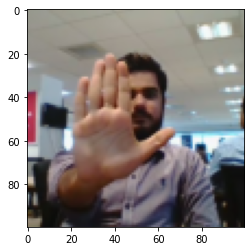

In [40]:
### Displaying sample batch data to display
print(sample_batch_data.shape)
fig, ax = plt.subplots()
ax.imshow(sample_batch_data[5,10,:,:,:])
plt.show()

# Model-1 
* Batch Size : 64
* Total Frames : 16
* Epochs : 20

In [30]:
batch_size = 64
total_frames = 16
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 20
train_generator, val_generator = getTrainNdValGenerators(batchSize=64, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model1_bSize64_frames16_epochs20';
callbacks_list = getCallBacksList(modelName, False)
model1_bSize64_frames16_epochs20 = defineModel(imageDataNdShape)
compileNdDisplaySummary(model1_bSize64_frames16_epochs20, 'adam')

[array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]
11 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                          

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]
Epoch 1/20
11/11 [==============================] - 67s 6s/step - loss: 1.9993 - categorical_accuracy: 0.3818 - val_loss: 4.2851 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 59s 6s/step - loss: 1.3451 - categorical_accuracy: 0.5455 - val_loss: 4.8044 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 64s 6s/step - loss: 1.3055 - categorical_accuracy: 0.5409 - val_loss: 3.5111 - val_categorical_accuracy: 0.2778 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 64s 6s/step - loss: 1.2548 - categorical_accuracy: 0.5955 - val_loss: 8.7461 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 63s 6s/step - loss: 1.1181 - categorical_accuracy: 0.5727 - val_loss: 4.3954

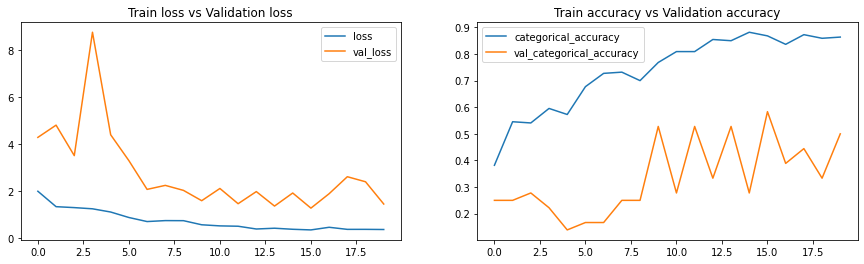

Max. Training Accuracy 0.8818181753158569
Max. Validaiton Accuracy 0.5833333134651184


In [31]:
model1_bSize64_frames16_epochs20_history = model1_bSize64_frames16_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model1_bSize64_frames16_epochs20_history)

###### Summary & Decision
* Model is Overfitted so lets try to start experimenting with batch size, frame size and epochs by considering trainable params as well
* Need to Experiment with increasing the frames and epochs

# Model-2
* Batch Size : 64
* Total Frames : 30
* Epochs : 30

In [34]:
batch_size = 64
total_frames = 30
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 30
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model2_bSize64_frames30_epochs30';
callbacks_list = getCallBacksList(modelName, False)
model2_bSize64_frames30_epochs30 = defineModel(imageDataNdShape)
compileNdDisplaySummary(model2_bSize64_frames30_epochs30, 'adam')

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]
11 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 13, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 48, 48, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.8213 - categorical_accuracy: 0.4182Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]
11/11 [==============================] - 118s 11s/step - loss: 1.8213 - categorical_accuracy: 0.4182 - val_loss: 14.0804 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - 121s 12s/step - loss: 1.3892 - categorical_accuracy: 0.4818 - val_loss: 10.5823 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - 115s 11s/step - loss: 1.0637 - categorical

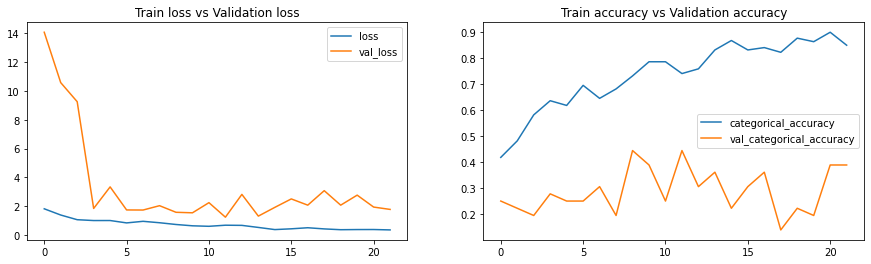

Max. Training Accuracy 0.8999999761581421
Max. Validaiton Accuracy 0.4444444477558136


In [35]:
model2_bSize64_frames30_epochs30_history = model2_bSize64_frames30_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model2_bSize64_frames30_epochs30_history)

##### Sumamry & Decision
* Validation accuracy got reduced and model is still overfitting
* Need to Try to reduce the trainable params and remodel the network

# Model-3
* Batch Size : 64
* Total Frames : 30
* Epochs : 20

* Reducing Parameters 

In [20]:
def defineModelForReducedParams(imageDataNdShape):
  
  ### Extract Data 
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)

  model = Sequential([
      Conv3D(16, (3, 3, 3), activation='relu', input_shape=inputShape),
      MaxPooling3D((2, 2, 2), padding='same'),
      BatchNormalization(),

      Conv3D(32, (3, 3, 3), activation='relu'),
      MaxPooling3D(pool_size=(1,2,2), padding='same'),
      BatchNormalization(),

      Conv3D(64, (3, 3, 3), activation='relu'),
      MaxPooling3D(pool_size=(1,2,2), padding='same'),
      BatchNormalization(),

      Flatten(),
      Dense(128, activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(64, activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(5, activation='softmax')
  ])
  return model

In [38]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 20
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model3_bSize64_frames30_epochs20';
callbacks_list = getCallBacksList(modelName, False)
model3_bSize64_frames20_epochs20 = defineModelForReducedParams(imageDataNdShape)
compileNdDisplaySummary(model3_bSize64_frames20_epochs20, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 18, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 9, 49, 49, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 9, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 24, 24, 32)    0         
 g3D)

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.4540 - categorical_accuracy: 0.4773Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 77s 8s/step - loss: 1.4540 - categorical_accuracy: 0.4773 - val_loss: 3.2030 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 78s 8s/step - loss: 1.4132 - categorical_accuracy: 0.5500 - val_loss: 2.3947 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 76s 8s/step - loss: 1.1339 - categorical_accuracy: 0.6182 - val_loss: 3.0272 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epo

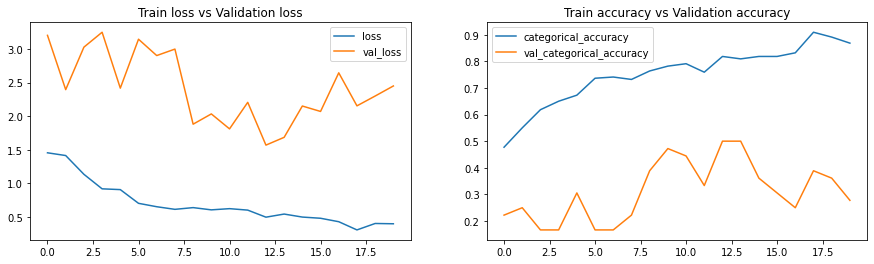

Max. Training Accuracy 0.9090909361839294
Max. Validaiton Accuracy 0.5


In [39]:
model3_bSize64_frames20_epochs20_history = model3_bSize64_frames20_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model3_bSize64_frames20_epochs20_history)

##### Summary & Decision
* Trainable params got reduced and model training, validation accuracy got increased. Model is Still Overfitting
* Need to Experiment by Increasing the epochs and reduce the frame size

# Model-4
* Btach Size: 64
* Total Frames: 20
* Number of Epochs: 30

### Experiementing as
* Reduced Params Model
* Increase the epochs so that model gets trained more
* Reduce the frame size so that train model on only important data in videos

In [29]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 30
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model6_bSize64_frames20_epochs30';
callbacks_list = getCallBacksList(modelName, False)
model6_bSize64_frames20_epochs30 = defineModelForReducedParams(imageDataNdShape)
compileNdDisplaySummary(model6_bSize64_frames20_epochs30, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 98, 98, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 49, 49, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 49, 49, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 24, 24, 32)    0         
 3D)   

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.8653 - categorical_accuracy: 0.3364 Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 216s 20s/step - loss: 1.8653 - categorical_accuracy: 0.3364 - val_loss: 3.4049 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - 219s 20s/step - loss: 1.2784 - categorical_accuracy: 0.5227 - val_loss: 2.5307 - val_categorical_accuracy: 0.1111 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - 216s 20s/step - loss: 1.2083 - categorical_accuracy: 0.5091 - val_loss: 1.6163 - val_categorical_accuracy: 0.1944 - lr: 0.0

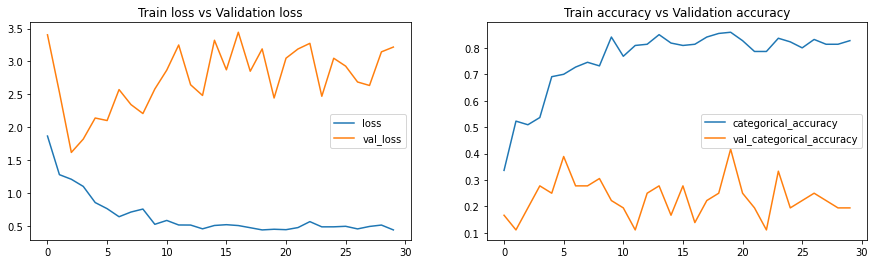

Max. Training Accuracy 0.8590909242630005
Max. Validaiton Accuracy 0.4166666567325592


In [30]:
model6_bSize64_frames20_epochs30_history = model6_bSize64_frames20_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model6_bSize64_frames20_epochs30_history)

##### Summary & Decision
* Reduction of framesize and increase of epochs doesnt help us. It reduced the accuracies. Model is Still Overfitting though
* Lets Experiment with combination by choosing 20 frames and 20epochs

# Model-5
* Batch Size : 64

* Total Frames : 20

* Epochs : 20

* Reducing Parameters

In [ ]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 20
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model4_bSize64_frames20_epochs20';
callbacks_list = getCallBacksList(modelName)
model4_bSize64_frames20_epochs20 = defineModelForReducedParams(imageDataNdShape)
compileNdDisplaySummary(model4_bSize64_frames20_epochs20, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]
11 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 118, 118, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 59, 59, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 59, 59, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 57, 57, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 29, 29, 32)    0         
 3D)   

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.7945 - categorical_accuracy: 0.4182Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]

Epoch 00001: saving model to model4_bSize64_frames20_epochs20_2022-01-2217_34_39.329009/model-00001-1.79455-0.41818-1.67219-0.19444.h5
11/11 [==============================] - 82s 7s/step - loss: 1.7945 - categorical_accuracy: 0.4182 - val_loss: 1.6722 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3334 - categorical_accuracy: 0.5273
Epoch 00002: saving model to model4_bSize64_frames20_epochs20_2022-01-2217_34_39.329009/model-00002-1.33341-0.52727

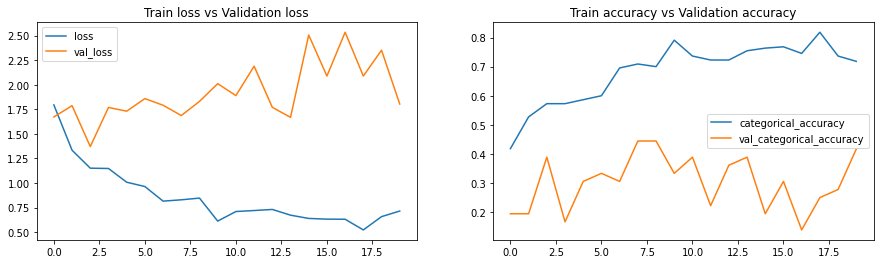

Max. Training Accuracy 0.8181818127632141
Max. Validaiton Accuracy 0.4444444477558136


In [ ]:
model4_bSize64_frames20_epochs20_history = model4_bSize64_frames20_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model4_bSize64_frames20_epochs20_history)

##### Summary & Decision
* Combination of frame size ssize 20 and epochs 20 doesnt help better. Overffiting problem is still remains same. Including with that model parameters also got increased much
* Lets try experimenting by moving Batch Normalization before the Max Pooling

# Model-6
* Batch Size : 64

* Total Frames : 20

* Epochs : 20

* Reducing Kernal Size and Trying Batch Normalization


In [71]:
def defineModelForReducedParamsNdReverseBatchNormalization(imageDataNdShape):
  
  ### Extract Data 
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)

  model = Sequential([
      Conv3D(16, (2, 2, 2), activation='relu', input_shape=inputShape),
      BatchNormalization(),
      MaxPooling3D((2, 2, 2), padding='same'),

      Conv3D(32, (2, 2, 2), activation='relu'),
      BatchNormalization(),
      MaxPooling3D(pool_size=(2, 2, 2), padding='same'),

      Conv3D(64, (2, 2, 2), activation='relu'),
      BatchNormalization(),
      MaxPooling3D(pool_size=(2, 2, 2), padding='same'),

      Conv3D(128, (2, 2, 2), activation='relu'),
      BatchNormalization(),
      MaxPooling3D(pool_size=(2, 2, 2), padding='same'),

      Flatten(),
      Dense(256, activation='relu'),

      Dense(128, activation='relu'),

      Dense(5, activation='softmax')
  ])
  return model

In [75]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 20
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model5_bSize64_frames20_epochs20';
callbacks_list = getCallBacksList(modelName)
model5_bSize64_frames20_epochs20 = defineModelForReducedParamsNdReverseBatchNormalization(imageDataNdShape)
compileNdDisplaySummary(model5_bSize64_frames20_epochs20, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_94 (Conv3D)          (None, 19, 99, 99, 16)    400       
                                                                 
 batch_normalization_92 (Bat  (None, 19, 99, 99, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_73 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_95 (Conv3D)          (None, 9, 49, 49, 32)     4128      
                                                                 
 batch_normalization_93 (Bat  (None, 9, 49, 49, 32)    128       
 chN

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.7625 - categorical_accuracy: 0.4682Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 76s 7s/step - loss: 1.7625 - categorical_accuracy: 0.4682 - val_loss: 1.6138 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 73s 7s/step - loss: 1.0808 - categorical_accuracy: 0.5909 - val_loss: 1.5371 - val_categorical_accuracy: 0.2778 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 77s 8s/step - loss: 0.7527 - categorical_accuracy: 0.7591 - val_loss: 2.0648 - val_categorical_accuracy: 0.3056 - lr: 0.0010
Epo

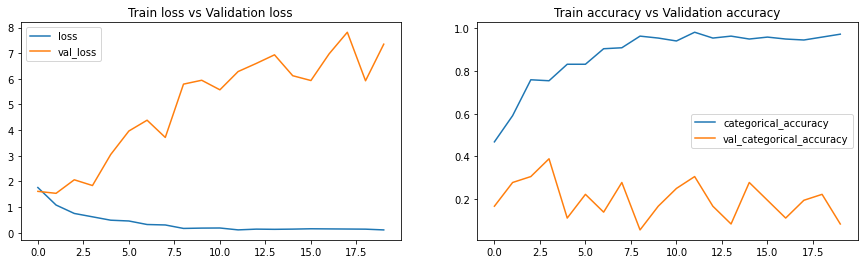

Max. Training Accuracy 0.9818181991577148
Max. Validaiton Accuracy 0.3888888955116272


In [76]:
model5_bSize64_frames20_epochs20_history = model5_bSize64_frames20_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model5_bSize64_frames20_epochs20_history)

#### Summary & Decision
* Model params got reduced and training accuracy is enormously increased. Overfitting is still bothering.
* Lets try to deeper the network with dropouts and normalization

In [29]:
def finalConv3dAloneModel(imageDataNdShape):
  ### Extract Data 
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)

  model = Sequential()
  model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=inputShape))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, (3, 3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
  model.add(Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(5,activation='softmax'))

  return model

# Model-7
* Batch Size: 64
* Total Frames: 20
* Epochs: 25

In [31]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 25
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model7_bSize64_frames20_epochs20';
callbacks_list = getCallBacksList(modelName)
model7_bSize64_frames20_epochs20 = finalConv3dAloneModel(imageDataNdShape)
compileNdDisplaySummary(model7_bSize64_frames20_epochs20, 'adam')

# b16 f20 e25

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 50, 50, 32)    13856     
     

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.7312 - categorical_accuracy: 0.3682Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 81s 7s/step - loss: 1.7312 - categorical_accuracy: 0.3682 - val_loss: 1.5639 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - 76s 8s/step - loss: 1.2530 - categorical_accuracy: 0.5182 - val_loss: 1.6058 - val_categorical_accuracy: 0.3056 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - 74s 7s/step - loss: 1.1777 - categorical_accuracy: 0.5318 - val_loss: 1.9757 - val_categorical_accuracy: 0.1389 - lr: 0.0010
Epo

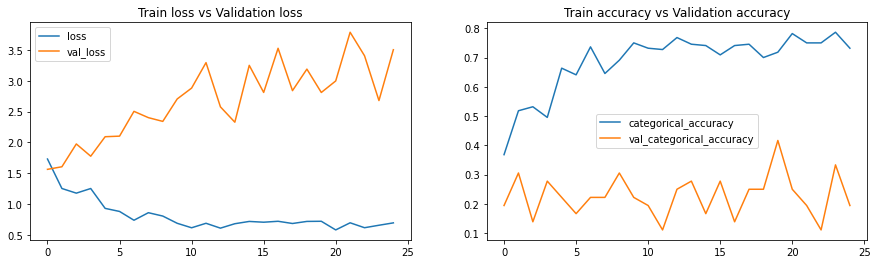

Max. Training Accuracy 0.7863636612892151
Max. Validaiton Accuracy 0.4166666567325592


In [32]:
model7_bSize64_frames20_epochs20_history = model7_bSize64_frames20_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model7_bSize64_frames20_epochs20_history)

#### Sumamry & Decision
* On creating the deep network, model paramters got reduced and training acuracy got reduced and validation got increased little bit. Overfitting got reduced which can be observed by difference in accuracies of train and validation sets
* Lets expereiment by using this model by making more deeper by adding a layer with LSTM.

# CONV2D + LSTM

In [34]:
### Define an Conv2d model with lstm
### Conv2d network structure is same as the conv3d network structure which gives us better result

def conv2dNdLstm(imageDataNdShape):
  ### Extract Data 
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)
  model = Sequential([
      TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=inputShape),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D((2, 2))),

      TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D((2, 2))),

      TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D((2, 2))),

      TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D((2, 2))),

      TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D((2, 2))),

      TimeDistributed(Flatten()),
      LSTM(256),
      Dropout(0.2),

      Dense(256, activation='relu'),
      Dropout(0.2),

      Dense(5, activation='softmax')
    ])
  return model

# Model-8
* Batch Size: 64
* Total Frames: 20
* Epochs: 30

In [39]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 30
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model8_bSize64_frames20_epochs30';
callbacks_list = getCallBacksList(modelName)
model8_bSize64_frames20_epochs30 = conv2dNdLstm(imageDataNdShape)
compileNdDisplaySummary(model8_bSize64_frames20_epochs30, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
     

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.4941 - categorical_accuracy: 0.3182Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 76s 7s/step - loss: 1.4941 - categorical_accuracy: 0.3182 - val_loss: 1.5817 - val_categorical_accuracy: 0.3611 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - 75s 7s/step - loss: 1.2801 - categorical_accuracy: 0.4773 - val_loss: 1.7884 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - 71s 7s/step - loss: 1.0912 - categorical_accuracy: 0.5864 - val_loss: 1.7213 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epo

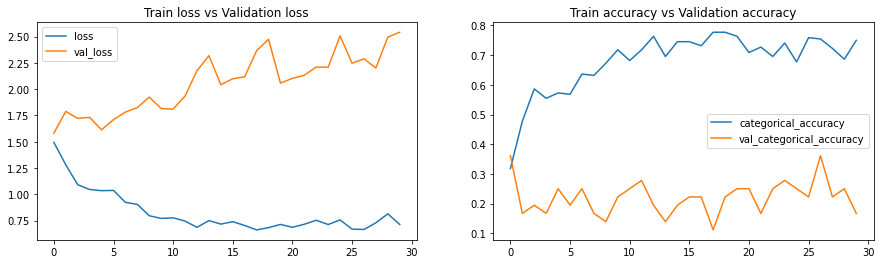

Max. Training Accuracy 0.7772727012634277
Max. Validaiton Accuracy 0.3611111044883728


In [40]:
model8_bSize64_frames20_epochs30_history = model8_bSize64_frames20_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model8_bSize64_frames20_epochs30_history)

#### SUmmary & Decision
* Train and validation accuracy doesnt got improved well. 
* Lets experiment by reducing the batch size

# Model-9
* Batch Size: 32
* Total Frames: 20
* Epochs: 30

In [41]:
batch_size = 32
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 30
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model9_bSize32_frames20_epochs30';
callbacks_list = getCallBacksList(modelName)
model9_bSize32_frames20_epochs30 = conv2dNdLstm(imageDataNdShape)
compileNdDisplaySummary(model9_bSize32_frames20_epochs30, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21 4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
     

Source path =  /Project_data/train/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.4483 - categorical_accuracy: 0.3857Source path =  /Project_data/val/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21/21 [==============================] - 141s 7s/step - loss: 1.4483 - categorical_accuracy: 0.3857 - val_loss: 1.6605 - val_categorical_accuracy: 0.1389 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 149s 7s/step - loss: 1.1133 - categorical_accuracy: 0.5238 - val_loss: 1.8223 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 143s 7s/step - loss: 1.0176 - categorical_accuracy: 0.5833 - val_loss: 1.8108 - val_categorical_accuracy: 0.1250 - lr: 0.0010


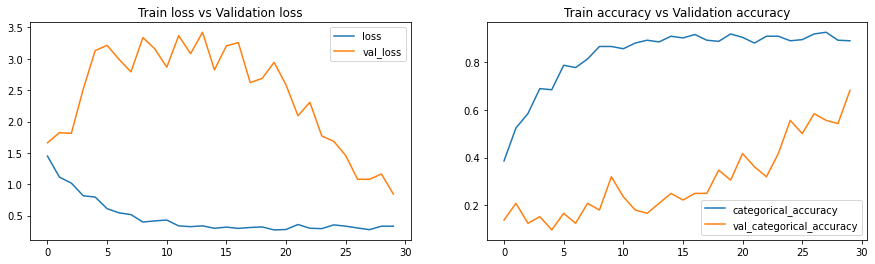

Max. Training Accuracy 0.9238095283508301
Max. Validaiton Accuracy 0.6805555820465088


In [42]:
model9_bSize32_frames20_epochs30_history = model9_bSize32_frames20_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model9_bSize32_frames20_epochs30_history)

##### Summary & Decision
* On reduction of batch size, raining accuracy got increased well and validation too. Model overfitting is still exists. 
* Lets Experiement with increasing the epochs so that model gets trained by more 5 epochs.

# Model-10
* Batch Size: 32
* Total Frames: 20
* Epochs: 35

In [43]:
batch_size = 32
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 35
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model10_bSize35_frames20_epochs30';
callbacks_list = getCallBacksList(modelName)
model10_bSize35_frames20_epochs30 = conv2dNdLstm(imageDataNdShape)
compileNdDisplaySummary(model10_bSize35_frames20_epochs30, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21 4
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
     

Source path =  /Project_data/train/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/35
21/21 [==============================] - ETA: 0s - loss: 1.3026 - categorical_accuracy: 0.4762Source path =  /Project_data/val/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21/21 [==============================] - 145s 7s/step - loss: 1.3026 - categorical_accuracy: 0.4762 - val_loss: 1.6159 - val_categorical_accuracy: 0.3194 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 140s 7s/step - loss: 1.1381 - categorical_accuracy: 0.5214 - val_loss: 1.6706 - val_categorical_accuracy: 0.2361 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 142s 7s/step - loss: 1.0376 - categorical_accuracy: 0.5667 - val_loss: 2.0667 - val_categorical_accuracy: 0.1667 - lr: 0.0010


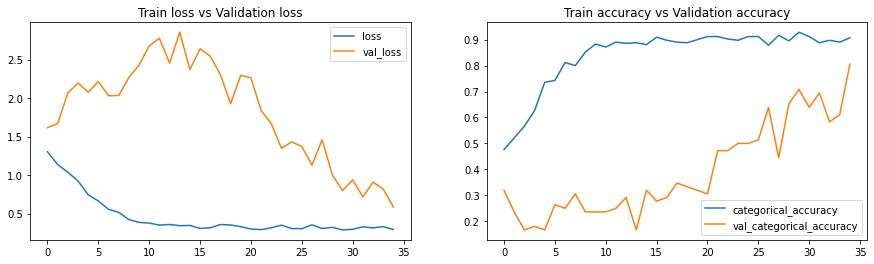

Max. Training Accuracy 0.9285714030265808
Max. Validaiton Accuracy 0.8055555820465088


In [44]:
model10_bSize35_frames20_epochs30_history = model10_bSize35_frames20_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model10_bSize35_frames20_epochs30_history)

##### Summary & Decision
* On increasing the epochs training accuracy doesnt change much but validation accuracy got oncreased. and overfitting got reduced some extent
* Lets experiment with Transfer learning to reduce the overfitting for more extent

# Transfer Learning

In [26]:
# imports for Loading the mobilenet 
from tensorflow.keras.applications import mobilenet

In [27]:
# Save the mobilenet network into a variable
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 1s 0us/step


In [28]:
# Create base model network for transfer learning 

# Input: Image and shape data, isGru (Deafult false which tells us to user LSTM) 
def modelWithTransferLearning(imageDataNdShape, isGru = False):
  ### Extract Data 
  total_frames = len(imageDataNdShape[0])
  img_height = imageDataNdShape[1]
  img_width = imageDataNdShape[2]
  img_channels = imageDataNdShape[3]

  # Create Input Shape
  inputShape = (total_frames, img_height, img_width, img_channels)

  model = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
  ])

  for layer in model.layers:
    layer.trainable = False

  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))

  if isGru:
    model.add(GRU(256))
  else:
    model.add(LSTM(256))

  model.add(Dropout(0.2))

  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(5, activation='softmax'))

  return model

Experimenting with LSTM

# Model-11
* Batch Size: 32
* Total Frames: 20
* Epochs: 35

In [50]:
batch_size = 32
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 35
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model11_bSize32_frames20_epochs35';
callbacks_list = getCallBacksList(modelName)
model11_bSize32_frames20_epochs35 = modelWithTransferLearning(imageDataNdShape)
compileNdDisplaySummary(model11_bSize32_frames20_epochs35, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21 4
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
     

Source path =  /Project_data/train/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/35
21/21 [==============================] - ETA: 0s - loss: 1.2791 - categorical_accuracy: 0.4976Source path =  /Project_data/val/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21/21 [==============================] - 142s 7s/step - loss: 1.2791 - categorical_accuracy: 0.4976 - val_loss: 1.3945 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 138s 7s/step - loss: 0.7300 - categorical_accuracy: 0.7810 - val_loss: 1.2278 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 139s 7s/step - loss: 0.4874 - categorical_accuracy: 0.8452 - val_loss: 0.9224 - val_categorical_accuracy: 0.6528 - lr: 0.0010


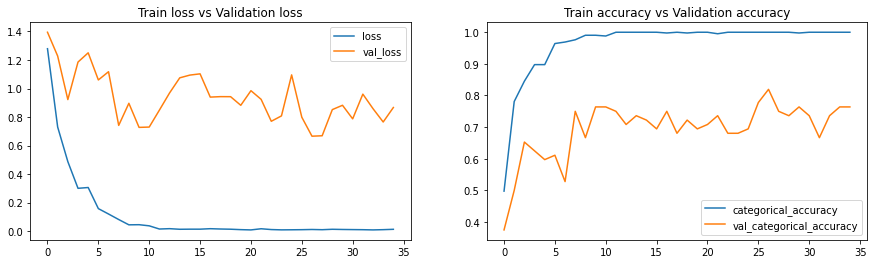

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8194444179534912


In [51]:
model11_bSize32_frames20_epochs35_history = model11_bSize32_frames20_epochs35.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model11_bSize32_frames20_epochs35_history)

##### Summary & Decision
* LSTM with less batch size doesnt give validation accuracy much. But Overfitting got reduced by some extent
* Lets try to increase the validation accuracy by increasing the batch size

# Model-12
* Batch Size: 64
* Total Frames: 20
* Epochs: 35

In [30]:
batch_size = 64
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 35
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model12_bSize64_frames20_epochs35';
callbacks_list = getCallBacksList(modelName)
model12_bSize64_frames20_epochs35 = modelWithTransferLearning(imageDataNdShape)
compileNdDisplaySummary(model12_bSize64_frames20_epochs35, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
       

Source path =  /Project_data/train/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/35
11/11 [==============================] - ETA: 0s - loss: 1.5032 - categorical_accuracy: 0.3545Source path =  /Project_data/val/ ; batch size =  64 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
11/11 [==============================] - 125s 11s/step - loss: 1.5032 - categorical_accuracy: 0.3545 - val_loss: 1.5146 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/35
11/11 [==============================] - 114s 11s/step - loss: 1.1762 - categorical_accuracy: 0.5636 - val_loss: 1.4384 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 3/35
11/11 [==============================] - 112s 11s/step - loss: 0.8955 - categorical_accuracy: 0.7045 - val_loss: 1.2805 - val_categorical_accuracy: 0.3611 - lr: 0.00

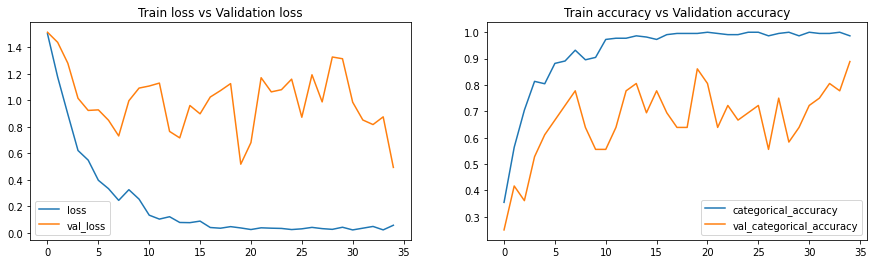

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8888888955116272


In [31]:
model12_bSize64_frames20_epochs35_history = model12_bSize64_frames20_epochs35.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model12_bSize64_frames20_epochs35_history)

#### Summary & Decision
* Increasing the bacth size increased the validation accuracy more. Overfitting got reduced.
* Lets try to reduce params using GRU

Experementing With GRU

# Model-13
* Batch Size: 64
* Total Frames: 20
* Epochs: 35

In [32]:
batch_size = 32
total_frames = 20
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 35
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model13_bSize32_frames20_epochs35';
callbacks_list = getCallBacksList(modelName)
model13_bSize32_frames20_epochs35 = modelWithTransferLearning(imageDataNdShape, True)
compileNdDisplaySummary(model13_bSize32_frames20_epochs35, 'adam')

[array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21 4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
     

Source path =  /Project_data/train/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
Epoch 1/35
21/21 [==============================] - ETA: 0s - loss: 1.2760 - categorical_accuracy: 0.5167Source path =  /Project_data/val/ ; batch size =  32 ; imageDataNdShape =  [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
21/21 [==============================] - 219s 10s/step - loss: 1.2760 - categorical_accuracy: 0.5167 - val_loss: 1.2374 - val_categorical_accuracy: 0.3611 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 227s 11s/step - loss: 0.6637 - categorical_accuracy: 0.7643 - val_loss: 1.1445 - val_categorical_accuracy: 0.5556 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 218s 11s/step - loss: 0.4322 - categorical_accuracy: 0.8548 - val_loss: 1.0363 - val_categorical_accuracy: 0.5972 - lr: 0.00

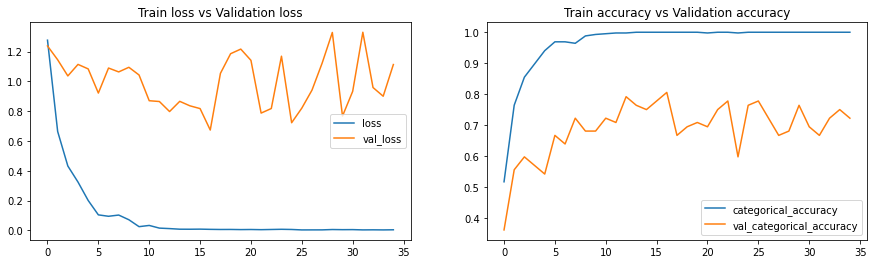

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8055555820465088


In [33]:
model13_bSize32_frames20_epochs35_history = model13_bSize32_frames20_epochs35.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model13_bSize32_frames20_epochs35_history)

#### Summary & Decision
* Model Params got reduced & Trainign accuracy remains good. Validation accuracy got reduced. 
* Lets experiement with reducing the batchsize and selecting only required frames with

# Model-14
* Batch Size: 5
* Total Frames: 16
* Epochs: 20

In [34]:
batch_size = 5
total_frames = 16
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 20
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model14_bSize5_frames16_epochs20';
callbacks_list = getCallBacksList(modelName, True)
model14_bSize5_frames16_epochs20 = modelWithTransferLearning(imageDataNdShape, True)
compileNdDisplaySummary(model14_bSize5_frames16_epochs20, 'adam')

[array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]
133 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                          

Source path =  /Project_data/train/ ; batch size =  5 ; imageDataNdShape =  [array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]
Epoch 1/20
133/133 [==============================] - 275s 2s/step - loss: 1.1239 - categorical_accuracy: 0.5429 - val_loss: 0.7976 - val_categorical_accuracy: 0.7121 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - 258s 2s/step - loss: 0.4725 - categorical_accuracy: 0.8316 - val_loss: 1.0036 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - 257s 2s/step - loss: 0.2959 - categorical_accuracy: 0.8947 - val_loss: 0.8743 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 4/20
133/133 [==============================] - 262s 2s/step - loss: 0.1641 - categorical_accuracy: 0.9444 - val_loss: 1.1763 - val_categorical_accuracy: 0.6333 - lr: 0.0010
Epoch 5/20
133/133 [==============================] - ETA: 0s - loss: 0.1625 - categorical_accuracy: 0.9353
Epoch 000

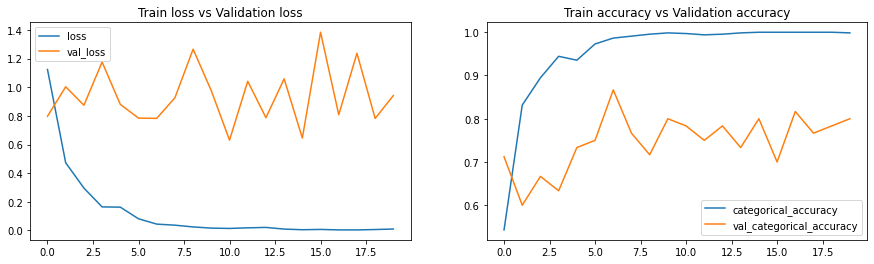

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8666666746139526


In [35]:
model14_bSize5_frames16_epochs20_history = model14_bSize5_frames16_epochs20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model14_bSize5_frames16_epochs20_history)

#### Summary & Decision 
* Model Params got reduced & Trainign accuracy remains good. Validation accuracy also got increased. Overfitting of the model got reduced by some extent 
* Lets Experiment with 30 epochs as well

[array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]
133 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                            

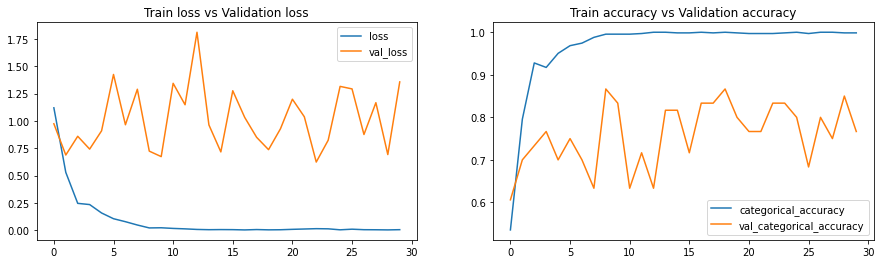

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8666666746139526


In [29]:
batch_size = 5
total_frames = 16
imageDataNdShape = getImageDataNdShape(total_frames)
print(imageDataNdShape);
num_epochs = 30
train_generator, val_generator = getTrainNdValGenerators(batchSize=batch_size, imageDataNdShapeInfo=imageDataNdShape)
steps_per_epoch, validation_steps = getStepsPerEpochNdValidationSteps(num_train_sequences, num_val_sequences, batch_size);
print(steps_per_epoch, validation_steps)
modelName = 'model14_bSize5_frames16_epochs30';
callbacks_list = getCallBacksList(modelName, True)
model14_bSize5_frames16_epochs30 = modelWithTransferLearning(imageDataNdShape, True)
compileNdDisplaySummary(model14_bSize5_frames16_epochs30, 'adam')
model14_bSize5_frames16_epochs30_history = model14_bSize5_frames16_epochs30.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotModelHistory(model14_bSize5_frames16_epochs30_history)

##### Summary & Decision
* Model Params got reduced & Trainign accuracy remains good. Validation accuracy also got increased. Overfitting of the model got reduced by some extent 
* Final model to save since training and validation accuracy are good and model is also not much overfitting.

# Total Observations

##### From them we consider model with GRU (Experiment-15) is considered as best model with good training and validation accuracy and overfitting of model is also got reduced for some extent.

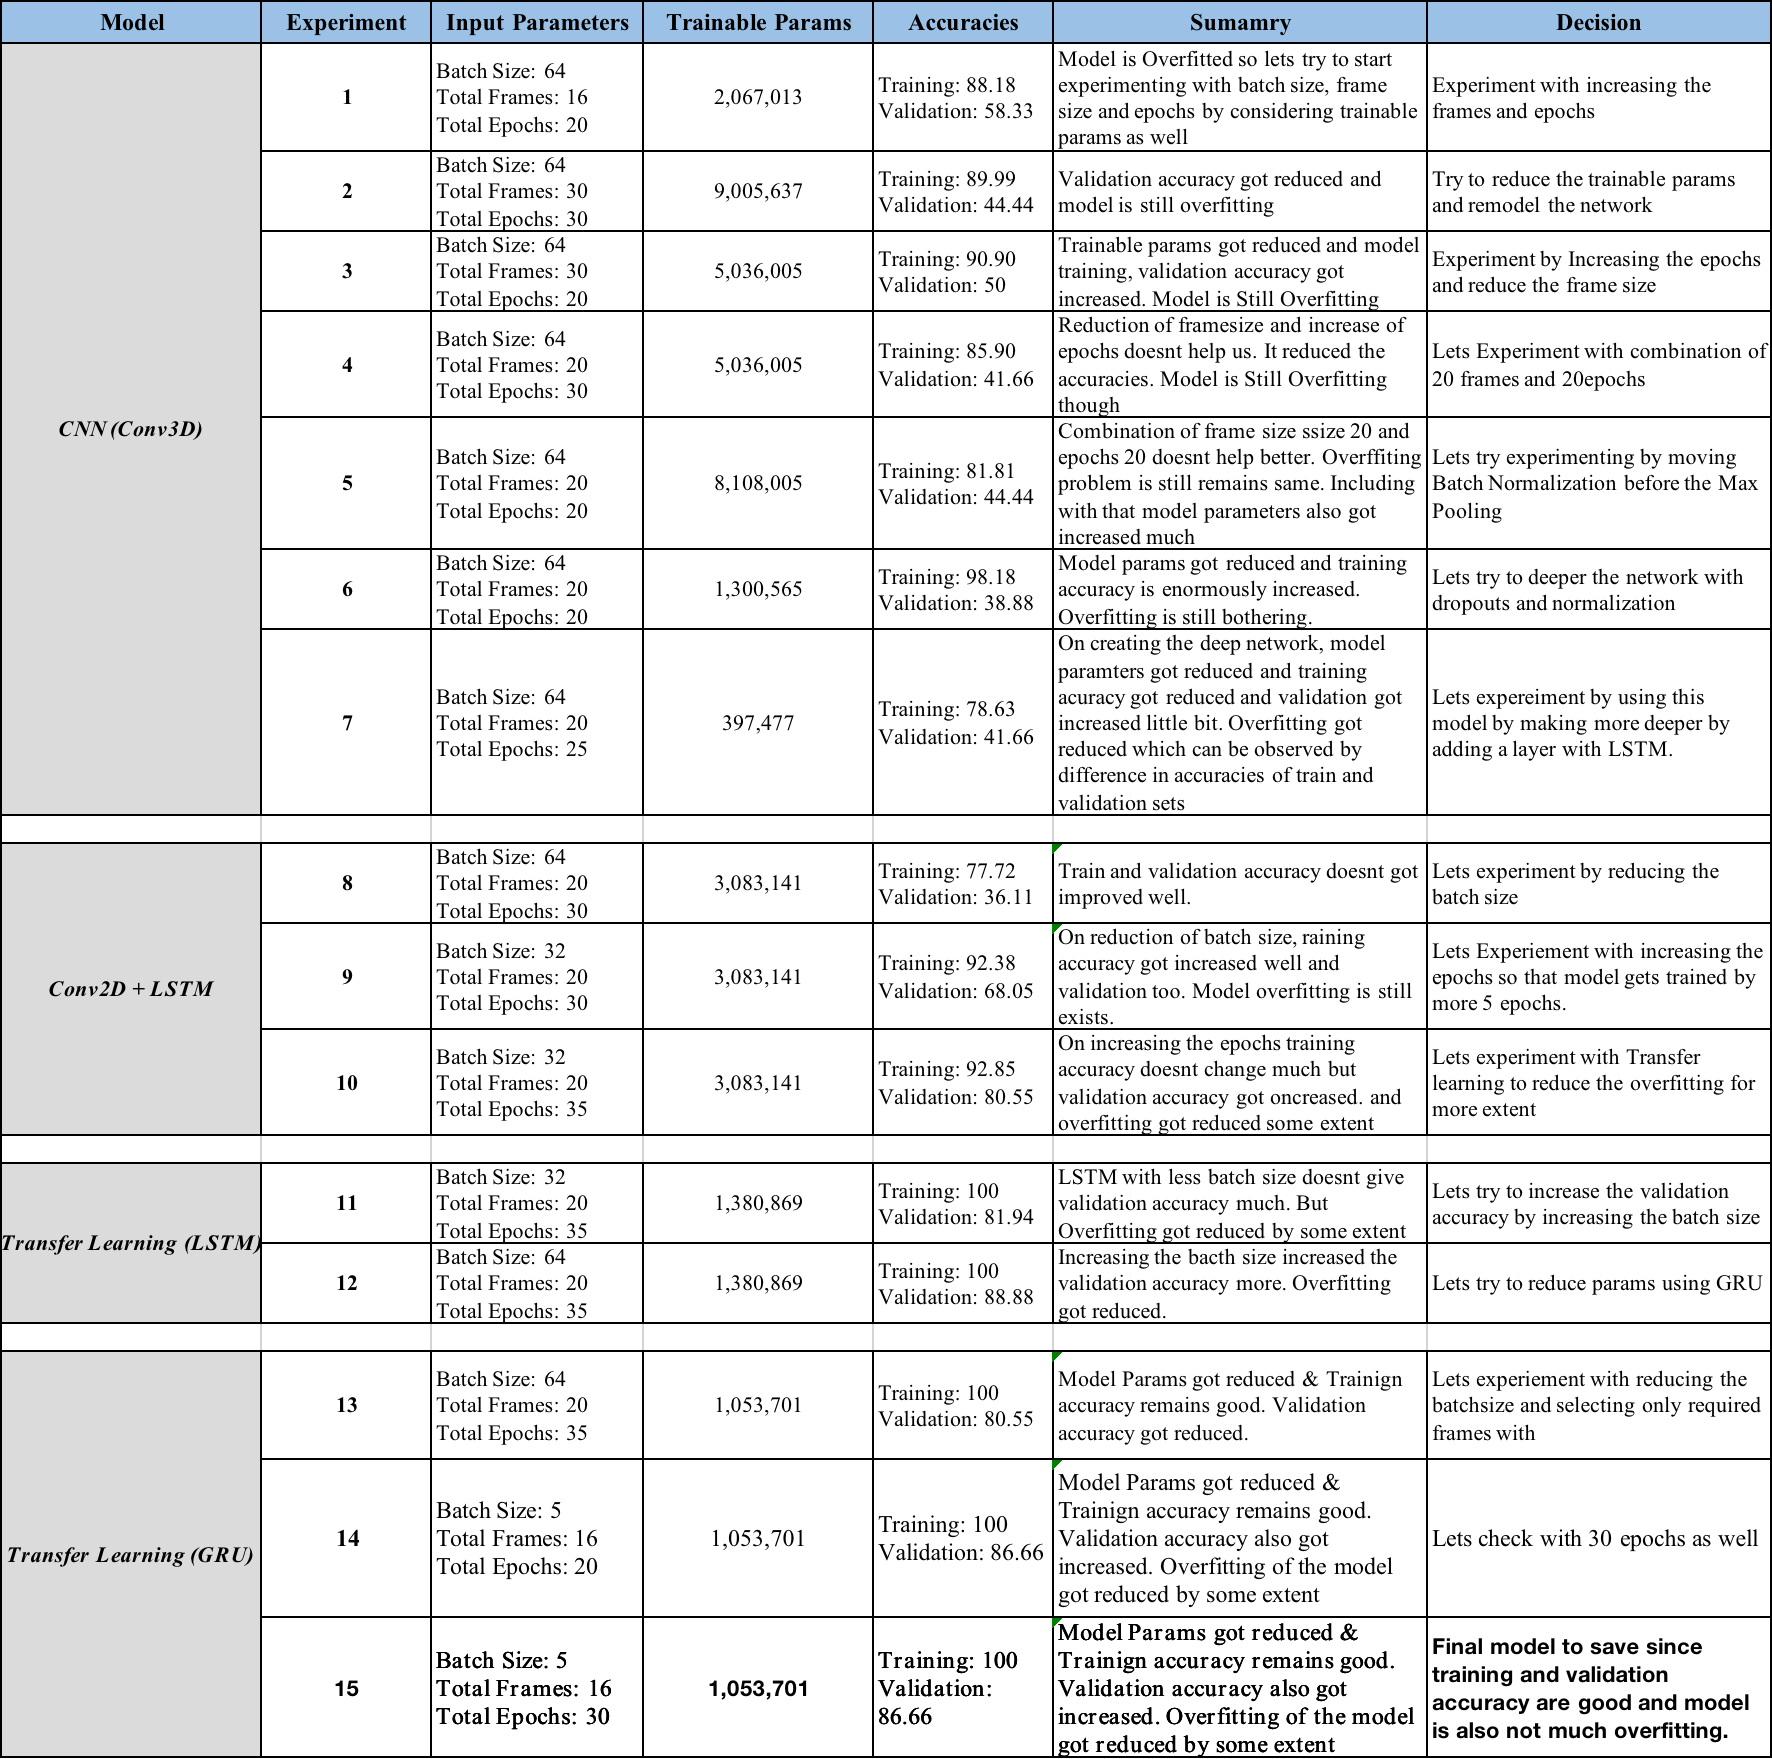